## In this notebook, we apply the Mourier methods that we create in [Notebook](Fourier%20Transform%20and%20Autocorrelational.ipynb)

### The following are the library that we shall use.

In [34]:
import numpy as np
from numpy.fft import fft2, ifft2
from scipy import ndimage

import warnings
warnings.filterwarnings('ignore')

def power_spectrum_2D(data):
    h = data.shape[0]
    w = data.shape[1]
    # center the data
    centered_z = data - np.mean(data)
    # Find Fourier transform
    F_f = fft2(centered_z)
    # Find the power spectrum density
    S_f = np.abs(F_f*np.conjugate(F_f))
    # Select positive wave numbers
    return S_f[:h//2, :w//2]

def auto_correlation_2D(data):
    h = data.shape[0]
    w = data.shape[1]
    # center the data
    centered_z = data - np.mean(data)
    # Find Fourier transform
    F_f = fft2(centered_z)
    # Find the power spectrum density
    S_f = F_f*np.conjugate(F_f)
    # Find the autocovariance by inverse Fourier transform
    R_t = ifft2(S_f)
    # select positive wave numbers, and then scales the value by signal size
    R_t = R_t[:h//2, :w//2].real/(h*w)
    # To make the Autocovariance to auto correlation, we need to divide
    # all the values by the variance. The variance of the signal is
    # in R_t[0, 0]
    R_corr_t = R_t/R_t[0,0]
    
    return R_corr_t

def circular_power_spectrum(ps2D, normalised=True):
    """ Find the circular power spectrum.
            
        ps2D: two-dimensional power spectrum        
        normalised: Normilises the returned 1D spectrum
    """
    h  = ps2D.shape[0]
    w  = ps2D.shape[1]
    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    # For each index in X and Y, finds its distance 
    # to origin (0,0)
    r = np.sqrt(X**2 + Y**2).astype(int)

    # Average all ps2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>w//2
    ps1D = ndimage.mean(ps2D, r, index=np.arange(0, w//2))
    
    # normalize
    if normalised:
        pwrTotal = np.sum(ps1D)
        ps1D    = ps1D/pwrTotal

    return ps1D

def radial_power_spectrum(ps2D, dTheta=1, rMin=0, rMax=None, normalised=True):
    """ Find the radial power spectrum.
    
        We can clip parts of the spectrum by tunning the 
        parameters.
    
        ps2D: two-dimensional power spectrum
        dTheta: (int) widths of the dTheta
        rMin: minimum radius
        rMax: maximum radius
        normalised: Normilises the returned 1D spectrum
    """
    h  = ps2D.shape[0]
    w  = ps2D.shape[1]        
    
    if rMax is None:
        rMax = np.sqrt(h**2 + w**2)
    # note that displaying PS as image inverts Y axis
    # create an array of integer angular slices of dTheta
    Y, X  = np.ogrid[0:h, 0:w]
    theta = np.rad2deg(np.arctan2(-Y, X))
    
    theta = np.mod(theta + dTheta/2 + 90 , 90  + dTheta/2 )        
    theta = dTheta * (theta//dTheta)
    theta = theta.astype(int)    

    # mask below rMin and above rMax by setting to -100
    R     = np.hypot(-Y, X)
    mask  = np.logical_and(R >= rMin, R <= rMax)    
    theta = theta + 100
    theta = np.multiply(mask, theta)
    theta = theta - 100
        
    # average all ps2D pixels with label 'theta' for 0<=theta<= 90 between rMin and rMax
    angF  = np.arange(0, 91 , int(dTheta))
    ps1D = ndimage.mean(ps2D, theta, index=angF)
    ps1D[np.isnan(ps1D)] = 0
    
    # normalize each sector to the total sector power
    if normalised:
        pwrTotal = np.sum(ps1D)
        ps1D    = ps1D/pwrTotal
    
    return angF, ps1D, theta

## Load the datasets

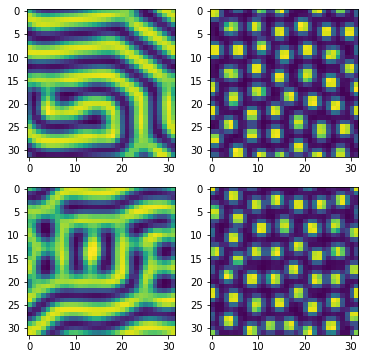

In [23]:
import matplotlib.pyplot as plt

dataset_1 = [ np.load(f"./data/turing_set_1_sample_{i}.npy") for i in range(1,6)]
dataset_2 = [ np.load(f"./data/turing_set_2_sample_{i}.npy") for i in range(1,6)]

_ = plt.figure(figsize=(6,6))
plt.subplot(2,2,1)
plt.imshow(dataset_1[0])
plt.subplot(2,2,2)
plt.imshow(dataset_2[0])
plt.subplot(2,2,3)
plt.imshow(dataset_1[1])
plt.subplot(2,2,4)
plt.imshow(dataset_2[2])
plt.show()

# Labyrinth and Circular Power spectrum

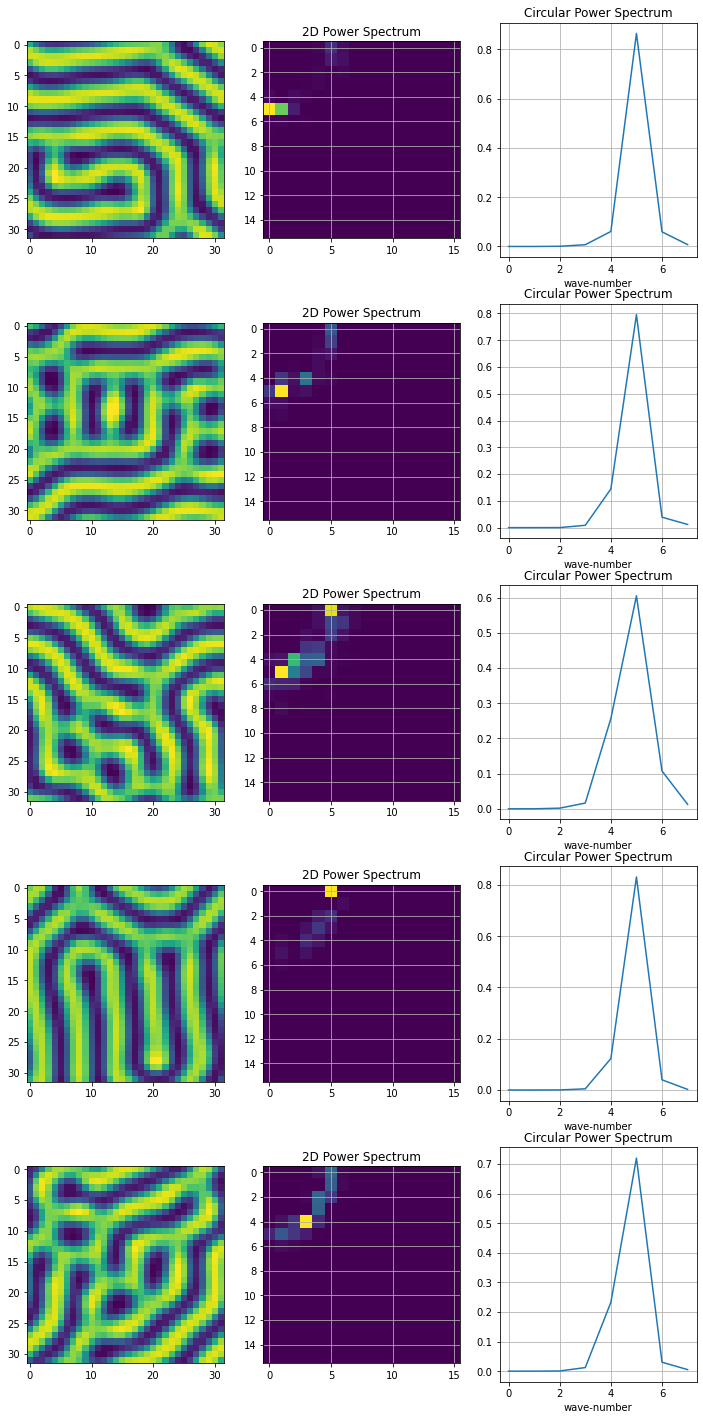

In [47]:
_ = plt.figure(figsize=(12,5*5))

i = 1
for sample in dataset_1:    
    ps2d = power_spectrum_2D(sample)
    ps_circular = circular_power_spectrum(ps2d)
    plt.subplot(5,3, i)
    i += 1
    plt.imshow(sample)
    plt.subplot(5,3, i)
    i += 1
    plt.imshow(ps2d)
    plt.grid()
    plt.title("2D Power Spectrum")
    plt.subplot(5,3, i)
    i += 1
    plt.plot(ps_circular)
    plt.grid()
    plt.title("Circular Power Spectrum")
    plt.xlabel("wave-number")
    
plt.show()

# Spots and Circular Power spectrum

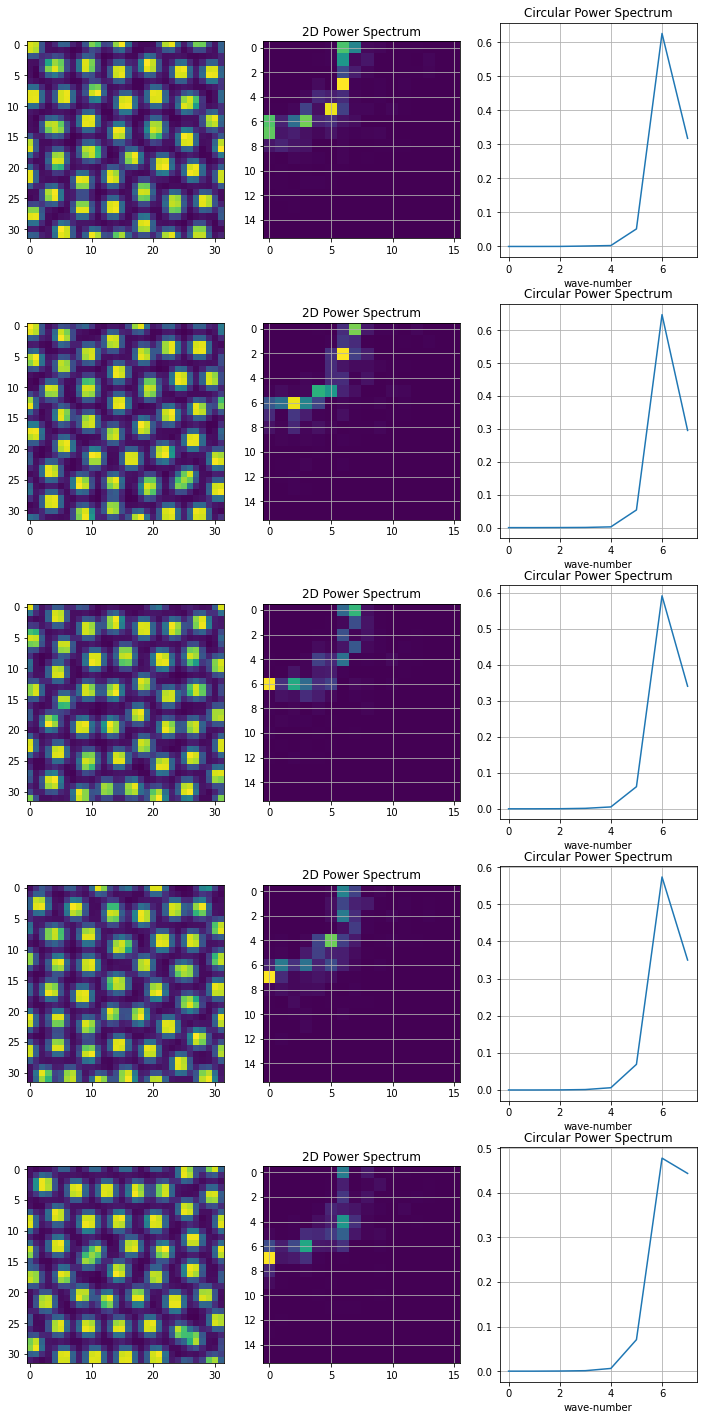

In [46]:
_ = plt.figure(figsize=(12,5*5))

i = 1
for sample in dataset_2:    
    ps2d = power_spectrum_2D(sample)
    ps_circular = circular_power_spectrum(ps2d)
    plt.subplot(5,3, i)
    i += 1
    plt.imshow(sample)
    plt.subplot(5,3, i)
    i += 1
    plt.imshow(ps2d)
    plt.grid()
    plt.title("2D Power Spectrum")
    plt.subplot(5,3, i)
    i += 1
    plt.plot(ps_circular)
    plt.grid()
    plt.title("Circular Power Spectrum")
    plt.xlabel("wave-number")
    
plt.show()

# Labyrinth and Radial Power spectrum

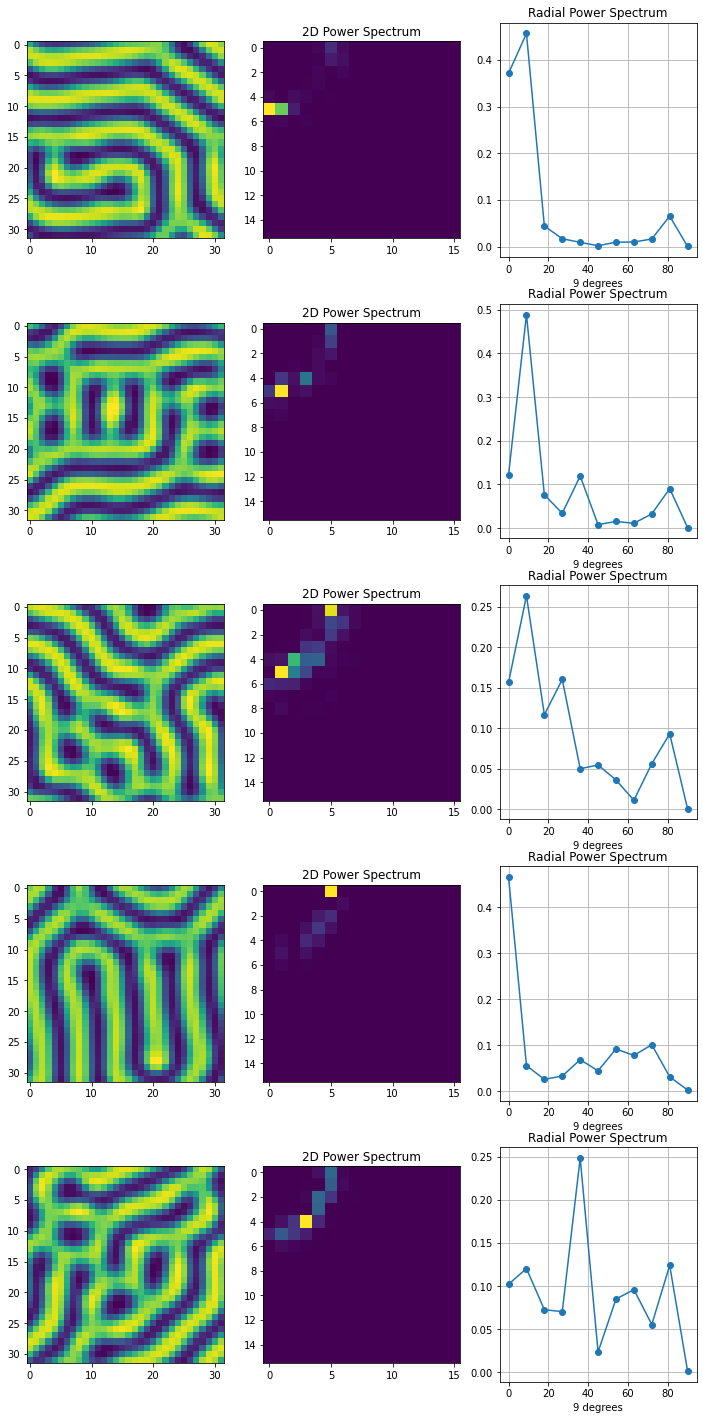

In [50]:
_ = plt.figure(figsize=(12,5*5))

i = 1
for sample in dataset_1:    
    ps2d = power_spectrum_2D(sample)
    angF, ps_radial, _ = radial_power_spectrum(ps2d, dTheta=9)
    plt.subplot(5,3, i)
    i += 1
    plt.imshow(sample)
    
    plt.subplot(5,3, i)
    i += 1
    plt.imshow(ps2d)    
    plt.title("2D Power Spectrum")
    
    plt.subplot(5,3, i)
    i += 1
    plt.plot(angF, ps_radial, '-o')
    plt.grid()    
    plt.xlabel("9 degrees")
    plt.title("Radial Power Spectrum")
    
plt.show()

# Spots and Radial Power spectrum

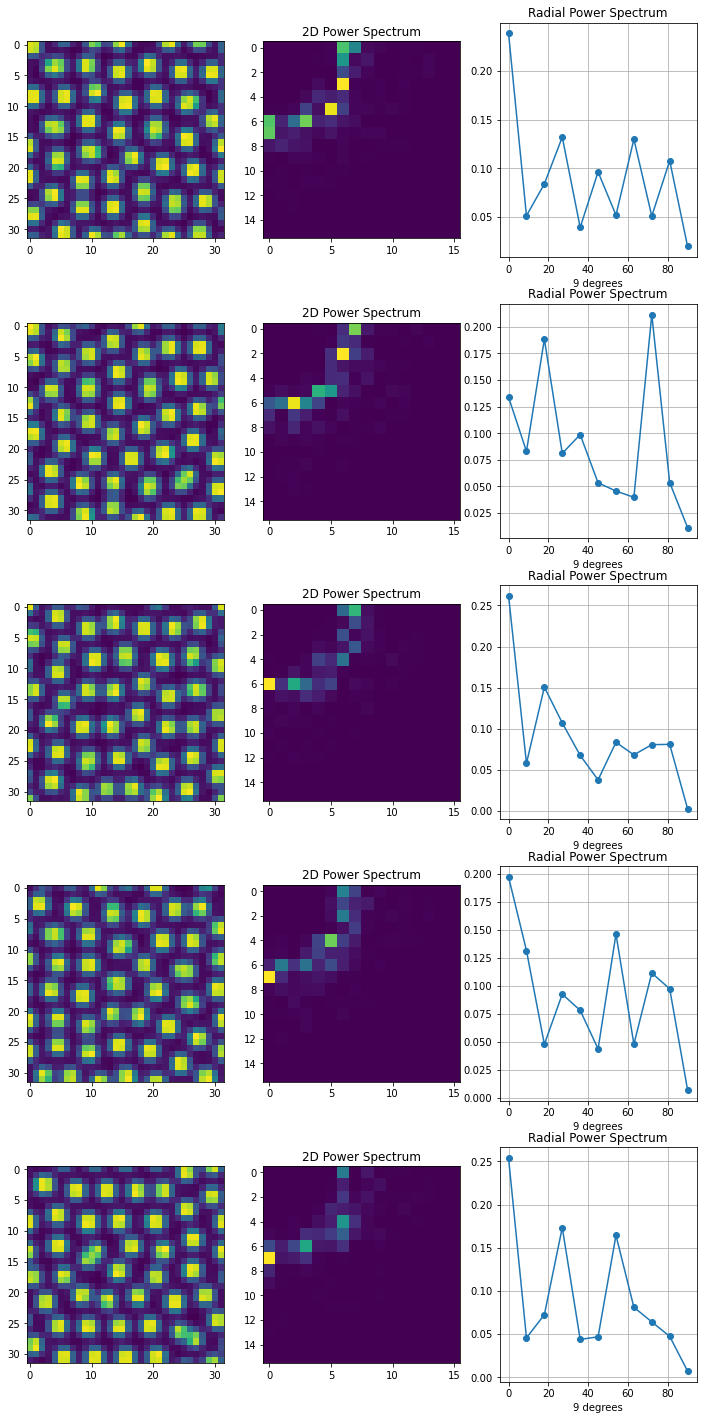

In [51]:
_ = plt.figure(figsize=(12,5*5))

i = 1
for sample in dataset_2:    
    ps2d = power_spectrum_2D(sample)
    angF, ps_radial, _ = radial_power_spectrum(ps2d, dTheta=9)
    plt.subplot(5,3, i)
    i += 1
    plt.imshow(sample)
    
    plt.subplot(5,3, i)
    i += 1
    plt.imshow(ps2d)    
    plt.title("2D Power Spectrum")
    
    plt.subplot(5,3, i)
    i += 1
    plt.plot(angF, ps_radial, '-o')
    plt.grid()    
    plt.xlabel("9 degrees")
    plt.title("Radial Power Spectrum")
    
plt.show()